# Task F

In [1]:
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

from models import *
from utils import * 
from optimizers import * 

# Create data
x = np.arange(0, 1, 0.05)
y = np.arange(0, 1, 0.05)
x, y = np.meshgrid(x, y)

# Compute z
z = FrankeFunction(x, y)

# Create features as pairs of (x, y)
features = np.stack([x.ravel(), y.ravel()], axis=1)
outputs = z.ravel()

# Split dataset into train and test set
x_train, x_test, y_train, y_test = train_test_split(features, outputs, test_size=0.2, random_state=20)

# Get polynomial features
degree = 5
poly = PolynomialFeatures(degree, include_bias=True)
x_train = poly.fit_transform(x_train)
x_test = poly.transform(x_test)

### Number of epochs

First, consider the simple case of a linear regression model that is trained using standard sgd. By using a small learning rate, we'll analyze the number of epochs.

0.59330684458089


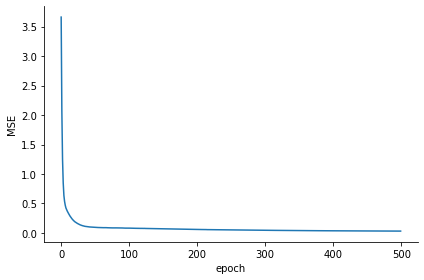

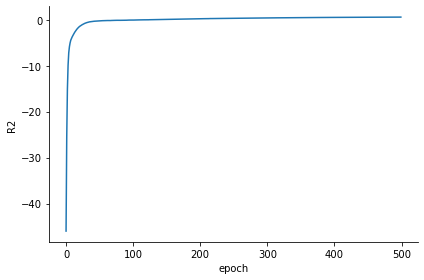

<AxesSubplot:xlabel='epoch', ylabel='R2'>

In [2]:
# Define parameters
epochs = 500 
lr = 1e-2
batch_size = 20

# Instantiate optimizer and model
optimizer = SGD(lr=lr)
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')

# Iterate over epochs
mse_losses = []
r2_scores = []
for _ in range(epochs):

    # Generate batches
    x_batches, y_batches = generate_batches(x_train, y_train, batch_size)

    # Iterate through batches
    for x, y in zip(x_batches, y_batches):
        
        # Determine the gradient for this batch
        gradient = model.gradient(x, y)
        
        # Update parameters using optimizer
        model.beta = optimizer.update(model.beta, gradient)

    # Get error
    y_hat = model.predict(x_test)
    mse = MSE(y_test, y_hat)
    r2 = R2(y_test, y_hat)
    
    # Append
    mse_losses.append(mse)
    r2_scores.append(r2)

print(r2_scores[-1])
plot_metric(y=mse_losses, show=True, save=True, x_label='epoch', y_label='MSE', name='f_mse_sgd_linear')
plot_metric(y=r2_scores, show=True, save=True, x_label='epoch', y_label='R2', name='f_r2_sgd_linear')

### Hyperparameter analysis

Now, we'll study the different hyperparameters in a structured way.

#### Learning rate and batch size

Analysis of different learning rates and batch sizes.

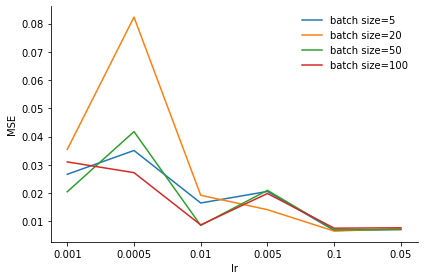

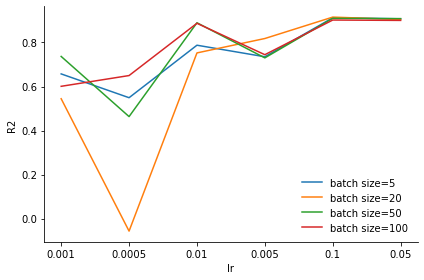

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [5]:
# Define parameters
epochs = 2000
lrs = [1e-3, 0.5e-3, 1e-2, 0.5e-2, 1e-1, 0.5e-1]
batch_sizes = [5, 20, 50, 100]

all_losses = []
all_scores = []
for batch_size in batch_sizes:
    
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        
        # Instantiate model and optimizer
        model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
        optimizer = SGD(lr=lr)
        
        # Train model
        model.train(x_train, y_train, optimizer, 10, epochs)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)


legend = ['batch size='+str(batch_size) for batch_size in batch_sizes]    
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_sgd_linear_lr-batch',
           legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_sgd_linear_lr-batch',
           legend=legend)

#### Adam optimizer

Now, we'll do the same except that in this case we'll use the Adam optimizer.

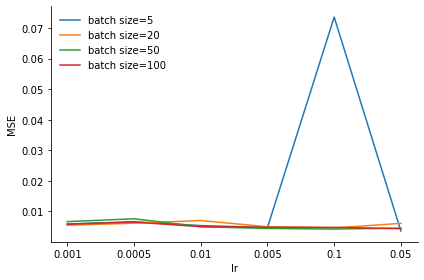

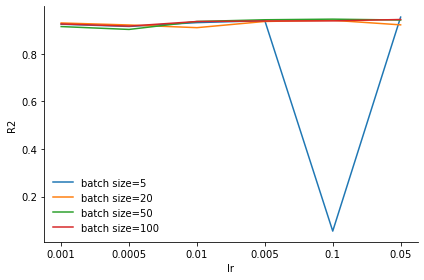

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [8]:
# Define parameters
epochs = 2000
lrs = [1e-3, 0.5e-3, 1e-2, 0.5e-2, 1e-1, 0.5e-1]
batch_sizes = [5, 20, 50, 100]

# Instantiate model
model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')

all_losses = []
all_scores = []
for batch_size in batch_sizes:
    
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        
        # Instantiate model and optimizer
        model = LinearRegression(dimension=x_train.shape[1], random_init=True, reduction='mean')
        optimizer = Adam(lr=lr)
        
        # Train model
        model.train(x_train, y_train, optimizer, 10, epochs)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)


legend = ['batch size='+str(batch_size) for batch_size in batch_sizes]    
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_adam_linear_lr-batch',
           legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_adam_linear_lr-batch',
           legend=legend)

#### Ridge regression

2000 epochs and a batch size of 100 have shown to work well previously. We'll use these values and study the learning rate and lambda for the Ridge regression case now.

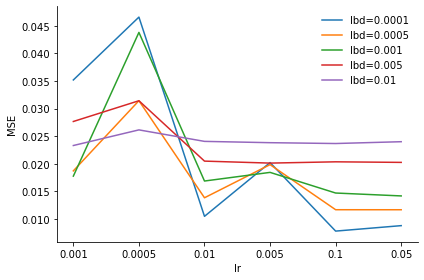

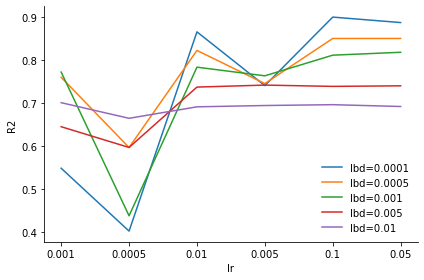

<AxesSubplot:xlabel='lr', ylabel='R2'>

In [12]:
# Define parameters
epochs = 2000
lrs = [1e-3, 0.5e-3, 1e-2, 0.5e-2, 1e-1, 0.5e-1]
lbds = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
batch_size = 100

all_losses = []
all_scores = []
for lbd in lbds:
    
    mse_losses = []
    r2_scores = []
    for lr in lrs:
        
        # Instantiate model and optimizer
        model = RidgeRegression(dimension=x_train.shape[1], random_init=True, reduction='mean', lbd=lbd)
        optimizer = SGD(lr=lr)
        
        # Train model
        model.train(x_train, y_train, optimizer, 10, epochs)

        y_hat = model.predict(x_test)
        mse = MSE(y_test, y_hat)
        r2 = R2(y_test, y_hat)

        # Append
        mse_losses.append(mse)
        r2_scores.append(r2)
        
    all_losses.append(mse_losses)
    all_scores.append(r2_scores)


legend = ['lbd='+str(lbd) for lbd in lbds]    
plot_metric(y=all_losses, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='MSE', name='f_mse_sgd_ridge_lr-lbd',
           legend=legend)

plot_metric(y=all_scores, x=np.arange(len(lrs)), nx_ticks=lrs, show=True, save=True, x_label='lr', y_label='R2', name='f_r2_sgd_ridge_lr-lbd',
           legend=legend)